# IT1244 Project

## Import Libraries

In [33]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
import torch as torch
from transformers import AutoModel
from transformers import AutoTokenizer, BertTokenizerFast
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier


In [28]:
def accuracy_score(y_test, y_pred):
    return sum(y_test == y_pred)/len(y_test)

## Data Importing

In [3]:
tweets = pd.read_csv("../Data/Raw/dataset.csv", header=None)
tweets.head()

,0,1
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Bert Encoding

In [5]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)
model = AutoModel.from_pretrained('vinai/bertweet-base')

In [6]:
def bert_encode(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state[:, 0, :]


In [ ]:
sentence_vectors = tweets[1].apply(lambda x: bert_encode(x))
data = np.array(list(map(lambda x: x[0], sentence_vectors)))
data_frame = pd.DataFrame(data)
data_frame.to_csv("../Data/Cleaned/BERT_Vectors.csv")

### Read the CSV data file

In [19]:
Bert_Encoded_Text = pd.read_csv("../Data/Cleaned/BERT_Vectors.csv").iloc[: , 1:]
X = Bert_Encoded_Text
y = tweets[0]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### K-NN Model

In [26]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [30]:
y_pred = knn.predict(X_test)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6896


#### N-fold Cross validation

In [34]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

In [37]:
results = list(map(lambda x: float(x), scores))

In [40]:
results

[0.65648,
 0.64578,
 0.67612,
 0.6713899999999999,
 0.68684,
 0.68375,
 0.69182,
 0.6899200000000001,
 0.69536,
 0.69342,
 0.69888,
 0.6965199999999999,
 0.69996,
 0.6984300000000001,
 0.70131,
 0.69845,
 0.70112,
 0.70009,
 0.70248,
 0.70123,
 0.70323,
 0.7026899999999999,
 0.7042700000000001,
 0.7030299999999999,
 0.7047000000000001,
 0.70383,
 0.7055499999999999,
 0.7040599999999999,
 0.70563,
 0.70394]

In [41]:
max(results)*100

70.563

Text(0, 0.5, 'Accuracy Score')

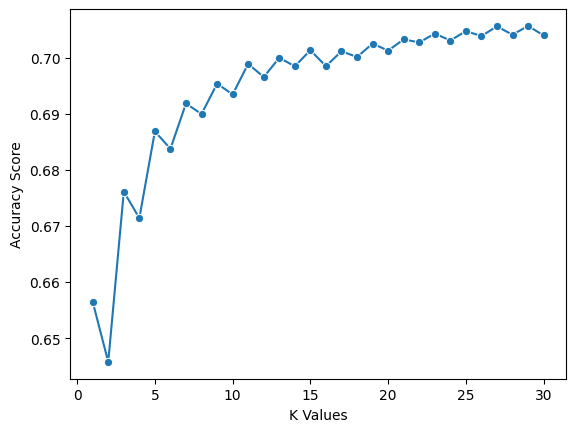

In [35]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

## Deep Learning Neural Network

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [129]:
import tensorflow as tf

In [106]:
def accuracy_val(model):
    y_hat = model.predict(X_test)
    return float((sum((y_hat >= 0.5) == y_test)/len(y_test))[0])*100

In [46]:
X.shape

(100000, 768)

In [56]:
y = np.array(y)
y = y.reshape(-1, 1)
y.shape

(100000, 1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [92]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [113]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='gelu'))
model.add(Dense(512, activation='gelu'))
model.add(Dense(512, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.7555 - loss: 0.4895 - val_accuracy: 0.8087 - val_loss: 0.4175
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.8343 - loss: 0.3721 - val_accuracy: 0.8170 - val_loss: 0.4083
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.8590 - loss: 0.3243 - val_accuracy: 0.8084 - val_loss: 0.4241
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.8829 - loss: 0.2716 - val_accuracy: 0.8056 - val_loss: 0.4378
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9123 - loss: 0.2092 - val_accuracy: 0.8028 - val_loss: 0.4997
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9401 - loss: 0.1465 - val_accuracy: 0.7960 - val_loss: 0.6066
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.9570 - loss: 0.1112 - val_accuracy: 0.7929 - val_loss: 0.7427
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.9666 -

In [133]:
import pydot

In [139]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)
model.summary()
accuracy_val(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,758,661 (10.52 MB)

 Trainable params: 919,553 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,839,108 (7.02 MB)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


78.83

In [112]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7626 - loss: 0.4868 - val_accuracy: 0.8098 - val_loss: 0.4147
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8294 - loss: 0.3768 - val_accuracy: 0.8158 - val_loss: 0.4102
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8572 - loss: 0.3260 - val_accuracy: 0.8128 - val_loss: 0.4185
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8839 - loss: 0.2694 - val_accuracy: 0.8049 - val_loss: 0.4652
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9116 - loss: 0.2079 - val_accuracy: 0.8017 - val_loss: 0.5255
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9419 - loss: 0.1480 - val_accuracy: 0.7956 - val_loss: 0.6211
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9587 - loss: 0.1073 - val_accuracy: 0.7945 - val_loss: 0.7989
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9670 -

In [ ]:
accuracy_val(model)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


81.64

In [109]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model0 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model0.add(Dense(512, input_dim=768, activation='gelu'))
model0.add(Dropout(0.3))  # Dropout to prevent overfitting
model0.add(Dense(256, activation='gelu'))
model0.add(Dropout(0.3))
model0.add(Dense(128, activation='gelu'))
model0.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model0.add(Dense(1, activation='sigmoid'))

# Compile the model
model0.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model0.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7240 - loss: 0.5444 - val_accuracy: 0.8116 - val_loss: 0.4202
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8113 - loss: 0.4163 - val_accuracy: 0.8169 - val_loss: 0.4030
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8241 - loss: 0.3898 - val_accuracy: 0.8189 - val_loss: 0.4025
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8328 - loss: 0.3729 - val_accuracy: 0.8213 - val_loss: 0.3973
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8402 - loss: 0.3593 - val_accuracy: 0.8213 - val_loss: 0.3951
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8481 - loss: 0.3433 - val_accuracy: 0.8227 - val_loss: 0.3916
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8521 - loss: 0.3341 - val_accuracy: 0.8214 - val_loss: 0.3998
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8582 -

In [136]:
accuracy_val(model0)
model0.summary()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,674,245 (6.39 MB)

 Trainable params: 558,081 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,116,164 (4.26 MB)

In [104]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model1 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model1.add(Dense(512, input_dim=768, activation='relu'))
model1.add(Dropout(0.3))  # Dropout to prevent overfitting
model1.add(Dense(256, activation='gelu'))
model1.add(Dropout(0.3))
model1.add(Dense(128, activation='mish'))
model1.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7226 - loss: 0.5420 - val_accuracy: 0.8038 - val_loss: 0.4254
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8142 - loss: 0.4143 - val_accuracy: 0.8177 - val_loss: 0.4049
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8242 - loss: 0.3897 - val_accuracy: 0.8194 - val_loss: 0.4021
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8322 - loss: 0.3775 - val_accuracy: 0.8217 - val_loss: 0.3957
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8393 - loss: 0.3632 - val_accuracy: 0.8253 - val_loss: 0.3913
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8435 - loss: 0.3528 - val_accuracy: 0.8247 - val_loss: 0.3897
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8473 - loss: 0.3421 - val_accuracy: 0.8210 - val_loss: 0.3950
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8511 -

In [137]:
model1.summary()
accuracy_val(model1)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,674,245 (6.39 MB)

 Trainable params: 558,081 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,116,164 (4.26 MB)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


81.105

In [80]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model2 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model2.add(Dense(512, input_dim=768, activation='gelu'))
model2.add(Dropout(0.3))  # Dropout to prevent overfitting
model2.add(Dense(256, activation='gelu'))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='gelu'))
model2.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.7567 - loss: 0.4998 - val_accuracy: 0.6636 - val_loss: 0.6819
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - accuracy: 0.8231 - loss: 0.3953 - val_accuracy: 0.7261 - val_loss: 0.5593
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.8341 - loss: 0.3744 - val_accuracy: 0.7588 - val_loss: 0.5016
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.8375 - loss: 0.3657 - val_accuracy: 0.7053 - val_loss: 0.5725
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.8443 - loss: 0.3556 - val_accuracy: 0.7190 - val_loss: 0.5409
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.8493 - loss: 0.3441 - val_accuracy: 0.7140 - val_loss: 0.5832
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - accuracy: 0.8506 - loss: 0.3364 - val_accuracy: 0.7413 - val_loss: 0.5321
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.8540 -

In [138]:
model2.summary()
accuracy_val(model2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,674,245 (6.39 MB)

 Trainable params: 558,081 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,116,164 (4.26 MB)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


84.48

In [81]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model3 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model3.add(Dense(512, input_dim=768, activation='gelu'))
model3.add(Dense(512, input_dim=768, activation='mish'))
model3.add(Dropout(0.3))  # Dropout to prevent overfitting
model3.add(Dense(256, activation='gelu'))
model3.add(Dense(256, activation='tanh'))
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='gelu'))
model3.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.8614 - loss: 0.3103 - val_accuracy: 0.7191 - val_loss: 0.5553
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.8638 - loss: 0.3022 - val_accuracy: 0.6758 - val_loss: 0.6828
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 531s 425ms/step - accuracy: 0.8710 - loss: 0.2951 - val_accuracy: 0.7150 - val_loss: 0.5909
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 63ms/step - accuracy: 0.8668 - loss: 0.2921 - val_accuracy: 0.7010 - val_loss: 0.6709
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 60ms/step - accuracy: 0.8734 - loss: 0.2841 - val_accuracy: 0.7382 - val_loss: 0.5234
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - accuracy: 0.8762 - loss: 0.2785 - val_accuracy: 0.7085 - val_loss: 0.6074
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 203s 159ms/step - accuracy: 0.8772 - loss: 0.2724 - val_accuracy: 0.7040 - val_loss: 0.6178
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.87

In [117]:
accuracy_val(model3)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


49.004999999999995

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model4 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model4.add(Dense(512, input_dim=768, activation='mish'))
model4.add(Dropout(0.3))  # Dropout to prevent overfitting
model4.add(Dense(256, activation='tanh'))
model4.add(Dropout(0.3))
model4.add(Dense(128, activation='gelu'))
model4.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model4.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 55ms/step - accuracy: 0.8883 - loss: 0.2527 - val_accuracy: 0.7014 - val_loss: 0.7275
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.8883 - loss: 0.2509 - val_accuracy: 0.7506 - val_loss: 0.5956
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.8885 - loss: 0.2484 - val_accuracy: 0.7148 - val_loss: 0.6902
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.8903 - loss: 0.2469 - val_accuracy: 0.7379 - val_loss: 0.6105
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.8916 - loss: 0.2402 - val_accuracy: 0.7344 - val_loss: 0.5432
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8931 - loss: 0.2396 - val_accuracy: 0.7288 - val_loss: 0.7637
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.8966 - loss: 0.2348 - val_accuracy: 0.7409 - val_loss: 0.6239
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8969 -

In [118]:
accuracy_val(model4)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


44.37

In [123]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model5 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model5.add(Dense(64, input_dim=768, activation='mish'))
model5.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7241 - loss: 0.5562 - val_accuracy: 0.8088 - val_loss: 0.4263
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8068 - loss: 0.4224 - val_accuracy: 0.8156 - val_loss: 0.4085
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8235 - loss: 0.3960 - val_accuracy: 0.8207 - val_loss: 0.4011
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8251 - loss: 0.3915 - val_accuracy: 0.8231 - val_loss: 0.3928
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8302 - loss: 0.3809 - val_accuracy: 0.8224 - val_loss: 0.3959
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8335 - loss: 0.3743 - val_accuracy: 0.8250 - val_loss: 0.3910
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8366 - loss: 0.3710 - val_accuracy: 0.8246 - val_loss: 0.3898
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8382 - loss: 0.3649 -

In [124]:
accuracy_val(model5)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


81.78999999999999

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model6 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model6.add(Dense(64, input_dim=768, activation='gelu'))
model6.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model6.add(Dense(1, activation='sigmoid'))

# Compile the model
model6.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model6.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7142 - loss: 0.5677 - val_accuracy: 0.8089 - val_loss: 0.4223
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8081 - loss: 0.4219 - val_accuracy: 0.8161 - val_loss: 0.4057
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8191 - loss: 0.3991 - val_accuracy: 0.8209 - val_loss: 0.3967
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8250 - loss: 0.3909 - val_accuracy: 0.8226 - val_loss: 0.3969
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8348 - loss: 0.3746 - val_accuracy: 0.8251 - val_loss: 0.3919
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8358 - loss: 0.3737 - val_accuracy: 0.8211 - val_loss: 0.3947
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8378 - loss: 0.3651 - val_accuracy: 0.8253 - val_loss: 0.3894
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8393 - loss: 0.3639 - 

In [170]:
accuracy_val(model6)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


81.575

In [ ]:
from tensorflow.keras.regularizers import l1_l2

model7 = Sequential()
model7.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model7.add(Dropout(0.3))  # Dropout to prevent overfitting
model7.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model7.add(Dense(1, activation='sigmoid'))

# Compile the model
model7.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model7.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6163 - loss: 2.6092 - val_accuracy: 0.7497 - val_loss: 0.6763
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6745 - loss: 0.6828 - val_accuracy: 0.7701 - val_loss: 0.6376
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6862 - loss: 0.6690 - val_accuracy: 0.7713 - val_loss: 0.6238
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6870 - loss: 0.6650 - val_accuracy: 0.7697 - val_loss: 0.6250
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6856 - loss: 0.6613 - val_accuracy: 0.7731 - val_loss: 0.6204
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6892 - loss: 0.6570 - val_accuracy: 0.7778 - val_loss: 0.6158
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6867 - loss: 0.6567 - val_accuracy: 0.7791 - val_loss: 0.6110
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6906 - loss: 0.6530 - 

In [169]:
accuracy_val(model7)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step


76.335

In [152]:
model8 = Sequential()
model8.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model8.add(Dense(1, activation='sigmoid'))

# Compile the model
model8.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model8.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6196 - loss: 2.9560 - val_accuracy: 0.7318 - val_loss: 0.7423
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6101 - loss: 0.7259 - val_accuracy: 0.7374 - val_loss: 0.6974
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6151 - loss: 0.7083 - val_accuracy: 0.7479 - val_loss: 0.6869
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6086 - loss: 0.7084 - val_accuracy: 0.7512 - val_loss: 0.6788
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6154 - loss: 0.7066 - val_accuracy: 0.7529 - val_loss: 0.6805
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6153 - loss: 0.7035 - val_accuracy: 0.7481 - val_loss: 0.6788
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6139 - loss: 0.7034 - val_accuracy: 0.7494 - val_loss: 0.6771
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6201 - loss: 0.6995 - 

In [168]:
accuracy_val(model8)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step


73.75

In [171]:
model9 = Sequential()
model9.add(Dense(16, input_dim=768, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model9.add(Dropout(0.3))  # Dropout to prevent overfitting
model9.add(Dense(16, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model9.add(Dense(1, activation='sigmoid'))

# Compile the model
model9.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model9.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6248 - loss: 2.6524 - val_accuracy: 0.7359 - val_loss: 0.6877
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6641 - loss: 0.6898 - val_accuracy: 0.7562 - val_loss: 0.6440
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6792 - loss: 0.6733 - val_accuracy: 0.7646 - val_loss: 0.6294
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6804 - loss: 0.6678 - val_accuracy: 0.7631 - val_loss: 0.6278
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6868 - loss: 0.6605 - val_accuracy: 0.7582 - val_loss: 0.6211
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6903 - loss: 0.6559 - val_accuracy: 0.7687 - val_loss: 0.6167
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6855 - loss: 0.6566 - val_accuracy: 0.7706 - val_loss: 0.6146
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6825 - loss: 0.6565 - 

In [172]:
accuracy_val(model9)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step


76.845

In [175]:
model10 = Sequential()
model10.add(Dense(16, input_dim=768, activation='gelu'))
model10.add(Dropout(0.3))  # Dropout to prevent overfitting
model10.add(Dense(16, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model10.add(Dense(1, activation='sigmoid'))

# Compile the model
model10.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model10.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model10)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6714 - loss: 0.6022 - val_accuracy: 0.7928 - val_loss: 0.4498
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7899 - loss: 0.4561 - val_accuracy: 0.8082 - val_loss: 0.4187
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8076 - loss: 0.4224 - val_accuracy: 0.8192 - val_loss: 0.4075
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8130 - loss: 0.4142 - val_accuracy: 0.8204 - val_loss: 0.3999
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8193 - loss: 0.4029 - val_accuracy: 0.8220 - val_loss: 0.3988
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8205 - loss: 0.4005 - val_accuracy: 0.8232 - val_loss: 0.3947
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8224 - loss: 0.3960 - val_accuracy: 0.8235 - val_loss: 0.3927
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8259 - loss: 0.3934 - 

81.575

In [177]:
model11 = Sequential()
model11.add(Dense(16, input_dim=768, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(8, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model11.add(Dense(1, activation='sigmoid'))

# Compile the model
model11.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model11.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model11)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6211 - loss: 0.6545 - val_accuracy: 0.7650 - val_loss: 0.5019
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7559 - loss: 0.5110 - val_accuracy: 0.7988 - val_loss: 0.4363
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7889 - loss: 0.4605 - val_accuracy: 0.8114 - val_loss: 0.4215
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8016 - loss: 0.4402 - val_accuracy: 0.8147 - val_loss: 0.4111
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8078 - loss: 0.4319 - val_accuracy: 0.8181 - val_loss: 0.4073
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8132 - loss: 0.4241 - val_accuracy: 0.8201 - val_loss: 0.4036
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8176 - loss: 0.4167 - val_accuracy: 0.8182 - val_loss: 0.4023
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8207 - loss: 0.4107 - 

81.755

In [181]:
model12 = Sequential()
model12.add(Dense(16, input_dim=768, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(8, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model12.add(Dense(1, activation='sigmoid'))

# Compile the model
model12.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model12.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model12)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6788 - loss: 0.5993 - val_accuracy: 0.7909 - val_loss: 0.4512
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7911 - loss: 0.4632 - val_accuracy: 0.8116 - val_loss: 0.4194
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8066 - loss: 0.4361 - val_accuracy: 0.8154 - val_loss: 0.4110
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8115 - loss: 0.4252 - val_accuracy: 0.8212 - val_loss: 0.4018
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8177 - loss: 0.4181 - val_accuracy: 0.8208 - val_loss: 0.4017
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8211 - loss: 0.4083 - val_accuracy: 0.8197 - val_loss: 0.3999
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8232 - loss: 0.4045 - val_accuracy: 0.8232 - val_loss: 0.3974
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8265 - loss: 0.3983 - 

81.815

In [182]:
model13 = Sequential()
model13.add(Dense(16, input_dim=768, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(8, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model13.add(Dense(1, activation='sigmoid'))

# Compile the model
model13.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model13.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model13)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5693 - loss: 0.7054 - val_accuracy: 0.7112 - val_loss: 0.5728
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6914 - loss: 0.5912 - val_accuracy: 0.7604 - val_loss: 0.5101
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7357 - loss: 0.5370 - val_accuracy: 0.7791 - val_loss: 0.4722
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7626 - loss: 0.4997 - val_accuracy: 0.7929 - val_loss: 0.4502
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7760 - loss: 0.4810 - val_accuracy: 0.8009 - val_loss: 0.4357
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7857 - loss: 0.4670 - val_accuracy: 0.8050 - val_loss: 0.4255
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7952 - loss: 0.4528 - val_accuracy: 0.8106 - val_loss: 0.4181
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8019 - loss: 0.4402 - 

81.105

In [183]:
model14 = Sequential()
model14.add(Dense(8, input_dim=768, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model14.add(Dense(1, activation='sigmoid'))

# Compile the model
model14.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model14.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model14)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5463 - loss: 0.6925 - val_accuracy: 0.7502 - val_loss: 0.5517
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7009 - loss: 0.5723 - val_accuracy: 0.7997 - val_loss: 0.4495
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7661 - loss: 0.5079 - val_accuracy: 0.8138 - val_loss: 0.4223
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7884 - loss: 0.4759 - val_accuracy: 0.8154 - val_loss: 0.4152
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7974 - loss: 0.4590 - val_accuracy: 0.8199 - val_loss: 0.4074
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8035 - loss: 0.4491 - val_accuracy: 0.8242 - val_loss: 0.4012
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8071 - loss: 0.4451 - val_accuracy: 0.8188 - val_loss: 0.4030
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8101 - loss: 0.4397 - 

81.66

In [192]:
model15 = Sequential()
model15.add(Dense(4, input_dim=768, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model15.add(Dense(1, activation='sigmoid'))

# Compile the model
model15.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model15.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model15)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5464 - loss: 0.6857 - val_accuracy: 0.7541 - val_loss: 0.5741
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6859 - loss: 0.6004 - val_accuracy: 0.8034 - val_loss: 0.4495
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7618 - loss: 0.5234 - val_accuracy: 0.8096 - val_loss: 0.4306
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7856 - loss: 0.4889 - val_accuracy: 0.8155 - val_loss: 0.4183
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7939 - loss: 0.4797 - val_accuracy: 0.8184 - val_loss: 0.4137
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7993 - loss: 0.4694 - val_accuracy: 0.8197 - val_loss: 0.4061
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8034 - loss: 0.4630 - val_accuracy: 0.8226 - val_loss: 0.4067
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8037 - loss: 0.4607 - 

81.33

In [199]:
model16 = Sequential()
model16.add(Dense(16, input_dim=768, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(8, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model16.add(Dense(1, activation='sigmoid'))

# Compile the model
model16.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model16.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
accuracy_val(model16)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5513 - loss: 0.7802 - val_accuracy: 0.7120 - val_loss: 0.5744
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6551 - loss: 0.6060 - val_accuracy: 0.7545 - val_loss: 0.5235
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7137 - loss: 0.5563 - val_accuracy: 0.7764 - val_loss: 0.4898
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7460 - loss: 0.5280 - val_accuracy: 0.7864 - val_loss: 0.4688
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7629 - loss: 0.5032 - val_accuracy: 0.7958 - val_loss: 0.4542
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7772 - loss: 0.4842 - val_accuracy: 0.8023 - val_loss: 0.4414
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7904 - loss: 0.4708 - val_accuracy: 0.8071 - val_loss: 0.4327
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7934 - loss: 0

81.38

In [205]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model17 = Sequential()
model17.add(Dense(16, input_dim=768, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(8, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model17.add(Dense(1, activation='sigmoid'))

# Compile the model
model17.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model17.fit(X_train, y_train, epochs=52, batch_size=64, validation_split=0.2)
accuracy_val(model17)

Epoch 1/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5695 - loss: 0.6799 - val_accuracy: 0.7098 - val_loss: 0.5997
Epoch 2/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6877 - loss: 0.5948 - val_accuracy: 0.7498 - val_loss: 0.5334
Epoch 3/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7268 - loss: 0.5475 - val_accuracy: 0.7717 - val_loss: 0.4938
Epoch 4/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7533 - loss: 0.5130 - val_accuracy: 0.7858 - val_loss: 0.4686
Epoch 5/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7698 - loss: 0.4921 - val_accuracy: 0.7954 - val_loss: 0.4510
Epoch 6/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7814 - loss: 0.4736 - val_accuracy: 0.8017 - val_loss: 0.4395
Epoch 7/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7905 - loss: 0.4584 - val_accuracy: 0.8056 - val_loss: 0.4320
Epoch 8/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7961 - loss: 0.4470 - 

82.145

In [206]:
model18 = Sequential()
model18.add(Dense(16, input_dim=768, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(8, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model18.add(Dense(1, activation='sigmoid'))

# Compile the model
model18.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model18.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model18)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5622 - loss: 0.7011 - val_accuracy: 0.7149 - val_loss: 0.5987
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6928 - loss: 0.6027 - val_accuracy: 0.7546 - val_loss: 0.5282
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7332 - loss: 0.5477 - val_accuracy: 0.7745 - val_loss: 0.4835
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7580 - loss: 0.5116 - val_accuracy: 0.7879 - val_loss: 0.4599
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7703 - loss: 0.4942 - val_accuracy: 0.7955 - val_loss: 0.4446
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7825 - loss: 0.4787 - val_accuracy: 0.8016 - val_loss: 0.4346
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7900 - loss: 0.4636 - val_accuracy: 0.8040 - val_loss: 0.4270
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7963 - loss: 0

81.875

In [207]:
models = [model, model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14, model15, model16, model17, model18]

In [208]:
model_results = []

for Model in models:
    model_results.append((Model.count_params(), accuracy_val(Model)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step


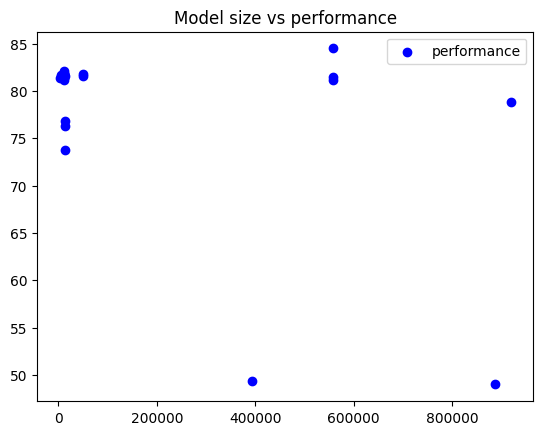

In [209]:
x,y = [], []

for Model in model_results:
    x.append(Model[0])
    y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


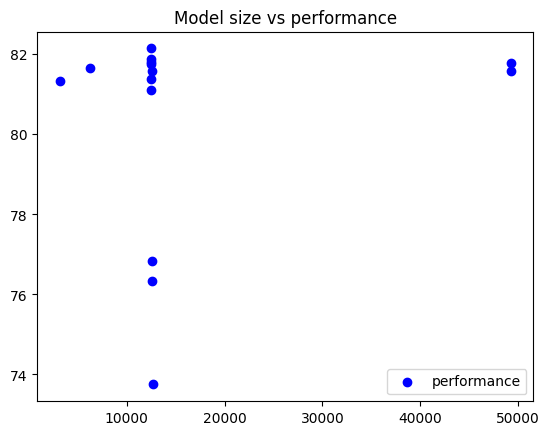

In [210]:
x,y = [], []

for Model in model_results:
    if (Model[0] < 100000):
        x.append(Model[0])
        y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


In [212]:
model_results

[(919553, 78.83),
 (558081, 81.43),
 (558081, 81.105),
 (558081, 84.48),
 (886529, 49.004999999999995),
 (394241, 49.39),
 (49281, 81.78999999999999),
 (49281, 81.575),
 (12593, 76.335),
 (12721, 73.75),
 (12593, 76.845),
 (12593, 81.575),
 (12481, 81.755),
 (12481, 81.815),
 (12481, 81.105),
 (6221, 81.66),
 (3149, 81.33),
 (12481, 81.38),
 (12481, 82.145),
 (12481, 81.875)]

In [218]:
model_family = []

In [216]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(512, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6333 - loss: 0.6372 - val_accuracy: 0.7819 - val_loss: 0.4630
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7774 - loss: 0.4748 - val_accuracy: 0.8067 - val_loss: 0.4240
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8012 - loss: 0.4364 - val_accuracy: 0.8129 - val_loss: 0.4076
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8157 - loss: 0.4066 - val_accuracy: 0.8198 - val_loss: 0.3980
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8259 - loss: 0.3893 - val_accuracy: 0.8221 - val_loss: 0.3926
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8350 - loss: 0.3739 - val_accuracy: 0.8214 - val_loss: 0.3909
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8378 - loss: 0.3648 - val_accuracy: 0.8224 - val_loss: 0.3872
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8462 - loss: 0.3535 

81.815

In [219]:
model_family.append(modeli)

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(256, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(modeli)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6135 - loss: 0.6586 - val_accuracy: 0.7717 - val_loss: 0.4798
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7620 - loss: 0.4962 - val_accuracy: 0.7987 - val_loss: 0.4368
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7925 - loss: 0.4501 - val_accuracy: 0.8103 - val_loss: 0.4185
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8077 - loss: 0.4243 - val_accuracy: 0.8184 - val_loss: 0.4058
Epoch 5/10
 995/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8178 - loss: 0.4079